In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax 
import flax.nn as nn

we set $P_{n,N} as $ $P\_local\_matvec$ and $P^{T}_{n,N}$ as $P\_local\_matvec\_t$. $N$ is fixed and $n$ is iterable. Here $P\_local\_matvec$  and $\P_local\_matvec\_t$ are set for the single iteration&

The same is for  $Projector \_  direct$. $Projector \_  direct$ is for $P_{n,N}P^T_{n,N}$ for single iteration


All this stuff is initialized with $x$

We initialize $w1$ and $w2$ with lecun and in $init\_BPX$ we  change (??) the values with $get\_init\_params$

In [2]:
def P_local_matvec(k, K, w1, w2, x):
    #S = jnp.diag(jnp.ones(2**k-1), 1)
    x1 = x.reshape((2**k, -1))
#     print('x1 shape',x1.shape)
    tmp = jnp.zeros(x1.shape)
#     print('tmp shape: ', tmp.shape)
    tmp = jax.ops.index_update(tmp, jax.ops.index[:-1, :], x1[1:, :])
    #tmp = S@x1 
    res = (x1@w1) + (tmp@w2)
#     print("re shape", res.shape)
    return res.flatten()


def P_local_matvec_t(k, K, w1, w2, x):
    #S = jnp.diag(jnp.ones(2**k-1), 1) #P.T = kron(I, eta.T)
    x1 = x.reshape((2**k, -1))     #Can we make a 2D version
    tmp = jnp.zeros(x1.shape)
    tmp = jax.ops.index_update(tmp, jax.ops.index[1:, :], x1[:-1, :])
    #res = x1@w1.T + (S.T@x1@w2.T)
    res = x1@w1.T + (tmp@w2.T)

    return res.flatten()


class Projector_direct(nn.Module):
    def apply(self, x, k, K):
        s = (K-k)
        sp = (2**s, 1)
        
        w1 = self.param('w1', sp, nn.initializers.lecun_normal())
        w2 = self.param('w2', sp, nn.initializers.lecun_normal())
        x1 = x.reshape((2**k, -1))
        y = P_local_matvec(k, K, w1, w2, x1)
        z = P_local_matvec_t(k, K, w1, w2, y)
        z = z.reshape(x.shape)
        return z


We set here $w1$ and $w2$ for a single iteration

In [3]:
def get_init_params(k, K):
    s = (K-k)
    xi = jnp.ones(2**s)
    eta = (jnp.arange(2**s) + 1)*1.0*(2**(-s))
    xi = jnp.reshape(xi, (-1, 1))
    eta = jnp.reshape(eta, (-1, 1))
    w1 = eta
    w2 = xi - eta
    w1 = w1*(2**(-s/2))
    w2 = w2*(2**(-s/2))
    return w1, w2

We compute BPX preconditioner here: $\sum^N_0 \frac{\epsilon+ \|\epsilon\|}{2}P_{n,N}P^T_{n,N}$

With $init\_BPX$ we initialize the parameters of the model: $name$, $scale\_name$  (what is it???), $w1$ and $w2$

In [4]:

class BPX(nn.Module):
    def apply(self, x, K):
        y = jnp.zeros(x.shape)
        for k in range(K+1):
            scale = self.param('scale_{0:d}'.format(k), (1, ), nn.initializers.ones)
            y = y + 0.5*(scale + abs(scale))*Projector_direct(x, k, K)
        return y


def init_BPX(K, model):
    params = {}
    for k in range(K+1):
        name = 'Projector_direct_{0:d}'.format(k)
        scale_name = 'scale_{0:d}'.format(k)
        w1, w2 = get_init_params(k, K)
        loc_params = {'w1': w1, 'w2': w2}
        params[name] = loc_params
        params[scale_name] = jnp.reshape(2**(-k), (1, ))*0.05
        #params[scale_name] = jnp.reshape(2**(-k), (1, ))*1e-2

    return model.replace(params=params)

In [43]:
rng = jax.random.PRNGKey(2010)
rng, key = jax.random.split(rng)

K = 4
B_cur = BPX.partial(K=K)
n = 2**K
x0 = jnp.ones(n)
print("x0. shape",x0.shape)
#зачем
_, init_params = B_cur.init(key, x0)
init_model = nn.Model(B_cur, init_params)
true_BPX = init_BPX(K, init_model)

x0. shape (16,)


In [30]:

z = jnp.diag(jnp.ones(n-1), -1)
e = jnp.eye(n)
lp = 2*e - z - z.T
lp = lp*(n+1)**2

c = 1e2 # convection coefficient

mat = lp
model = true_BPX

In [31]:
#model = opt.target
eye_mat = jnp.eye(n)
# mat1 = mat

z = eye_mat.reshape((n, n))
batch_model = jax.vmap(model) #We want to have ||(I - tau*A*B)||->min
prec = batch_model(z).reshape(eye_mat.shape)
#prec = get_BPX(K)
prec_mat = prec@mat@prec
S_mat = eye_mat - prec_mat
jnp.linalg.norm(S_mat, 2)

DeviceArray(0.9943236, dtype=float32)

In [32]:
s = jnp.linalg.svd(prec_mat)[1]
s[0], s[-1] 

(DeviceArray(0.14040501, dtype=float32),
 DeviceArray(0.00567643, dtype=float32))

In [33]:
s[0] / s[-1] 

DeviceArray(24.734718, dtype=float32)

In [44]:
def loss(dpx_model, mat, x):
    sz = x.shape
    y = x
    dpx_model_batch = jax.vmap(dpx_model, 1, 1) 
    for i in range(3):
        z = y.reshape(y.shape) #зачем?
        
        By = dpx_model_batch(z) #инииализация вектором Х
        By = jnp.reshape(By, y.shape)#получение предобуславлевателя
        By = mat@By #предобуславлливаем матрицу лапласа (почему не By@mat@By)?????
        By = dpx_model_batch(By) #зачем????
        y = y - By # что в этом. случае у??
    return jnp.mean(jnp.einsum('ib, ib->b', y, y)) 

I have no idea what update method is doing

In [36]:
@jax.jit
def update(opt, x):
    l1, grad1 = jax.value_and_grad(loss)(opt.target, mat, x)
    l2, grad2 = jax.value_and_grad(loss)(opt.target, lp, x)
    grad = jax.tree_multimap(lambda x, y: x + y, grad1, grad2)
    return l1+l2, opt.apply_gradient(grad)

In [37]:
n = 2**K
batch_size = 512
x_batch = jax.random.normal(key, (n, batch_size))
x_batch = x_batch/jnp.linalg.norm(x_batch, axis=0)[None, :]

In [38]:
opt = flax.optim.Adam(1e-5).create(model)

In [39]:
for _ in range(10000):
    loss_val, opt = update(opt, x_batch)
print(loss_val)

0.013151551


In [40]:
model = opt.target
params_final = model.params

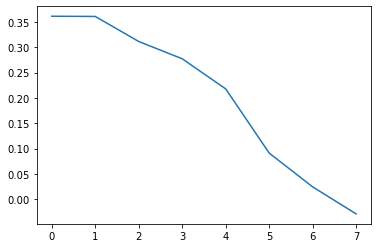

In [41]:
plt.plot(model.params['Projector_direct_1']['w2'])

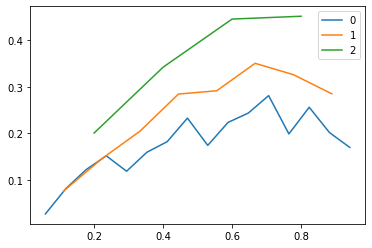

In [42]:

fun2 = model.params['Projector_direct_2']['w1']
fun1 = model.params['Projector_direct_1']['w1']
fun0 = model.params['Projector_direct_0']['w1']
xx0 = jnp.linspace(0, 1, 2**K+2)[1:-1]
xx1 = jnp.linspace(0, 1, 2**(K-1)+2)[1:-1]
xx2 = jnp.linspace(0, 1, 2**(K-2)+2)[1:-1]

plt.plot(xx0, fun0, label='0')
plt.plot(xx1, fun1, label='1')
plt.plot(xx2, fun2, label='2')
plt.legend()

1) что делает мето апдейт? (mat и lp  одно и то же)







3) почему иы ссразу не можем инициализировать проекторы матрицей лапласа?


4) почему $x\_batch$ именно такой ?


5) почему мы вычитаем из элементов $x\_batch$ y = y - By

6) вопросы в лоссе

In [45]:
import numpy as np

In [46]:
b = np.arange(5)

In [76]:
c = np.arange(6).reshape(2,3)
# c[0][0] =10
c

array([[0, 1, 2],
       [3, 4, 5]])

In [83]:
np.einsum(' ib->b', c)

array([ 3, 12])

In [81]:
np.einsum(' ib', c) , np.einsum(' ib->b', c) 

(array([[0, 3],
        [1, 4],
        [2, 5]]),
 array([3, 5, 7]))

In [82]:
np.einsum('ib,  ib->b', c, c) 

array([ 9, 17, 29])

In [84]:
d = np.einsum(' ib', c)

In [85]:
d

array([[0, 3],
       [1, 4],
       [2, 5]])

In [86]:
d@c

array([[ 9, 12, 15],
       [12, 17, 22],
       [15, 22, 29]])

2) jnp.mean(jnp.einsum('ib, ib->b', y, y)) ??????????????????????????÷ up